# SNAX package tutorial - simulations

In [1]:
from snewpy.neutrino import Flavor
import os
from tqdm.notebook import tqdm
import numpy as np
from multimessenger.supernova import Supernova_Models as sn
from multimessenger.supernova.Plotter import Plotter
import plotly.express as px
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
import straxen
straxen.print_versions(('strax', 'straxen', 'cutax', 'wfsim'))

*** Detector definition message ***
You are currently using the default XENON10 template detector.



,module,version,path,git
0,python,3.8.13,/opt/XENONnT/anaconda/envs/XENONnT_development...,None
1,strax,1.2.3,/opt/XENONnT/anaconda/envs/XENONnT_development...,None
2,straxen,1.8.3,/opt/XENONnT/anaconda/envs/XENONnT_development...,None
3,cutax,1.13.0,/dali/lgrandi/xenonnt/software/cutax/latest/cutax,None
4,wfsim,1.0.1,/home/melih/software/WFSim/wfsim,branch:master | d72c1b3


The `SNAX` is a wrapper around `snewpy` and it allows to compute CEvNS rates for all the snewpy models.

Each model contains variuous simulations with e.g. different EoS, or different progenitor properties. <br>
When only `model_name` is passed to `sn.Models()` it displays the existing files and asks you to select one. Otherwise, `filename` or `index` can be passed. <br>
Once the model is executed, and after every heavy computation the data is saved, and the next time it is directly fetched from the stored data. <br>
The output folder can be specified with the `storage` argument.

In [3]:
m = sn.Models("Nakazato_2013", index=7)

> You chose ~wisely~ ->	   [7]	nakazato-shen-z0.02-t_rev100ms-s20.0.fits
> Retrieving object self.storage/Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s20_0_fits.pickle


In [4]:
m

**Nakazato_2013 Model**: nakazato-shen-z0.02-t_rev100ms-s20.0.fits

|Parameter|Value|
|:--------|:----:|
|Progenitor mass | $20$ $\mathrm{M_{\odot}}$|
|EOS | SHEN |
|Metallicity | 0.02 |
|Revival time | $100$ $\mathrm{ms}$|
|composite | Xenon|
|duration | 20.05 s|
|distance | 10.0 kpc|
|volume | 5.9 t|
|executed | True|
|SN rate | 52 ct|

In [5]:
m.display_history

,date,version,user,history
0,2022/08/23 - 13:56 UTC,1.2.0,melih,Data Saved!
1,2022/08/23 - 13:57 UTC,1.2.0,melih,Fluxes computed!
2,2022/08/23 - 13:57 UTC,1.2.0,melih,Data Saved!
3,2022/08/23 - 13:57 UTC,1.2.0,melih,simulation Nakazato7_highstat is requested!
4,2022/08/23 - 13:57 UTC,1.2.0,melih,Data Saved!
5,2022/08/23 - 14:09 UTC,1.2.0,melih,simulation Nakazato7_highstat_st2 is requested!
6,2022/08/23 - 14:34 UTC,1.2.0,melih,simulation Nakazato7_highstat is requested!
7,2022/08/23 - 14:34 UTC,1.2.0,melih,Data Saved!
8,2022/08/23 - 14:34 UTC,1.2.0,melih,simulation Nakazato7_highstat_st2 is requested!


In [6]:
m.compute_rates()

Computing for all isotopes:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

> Rates are computed at the source for 1 atom see rateper_Er/t attr (use scale_rates() for distance & volume)


These parts are better done in dali/midway. <br>


In [7]:
import nestpy
import pandas as pd
import straxen
downloader = straxen.MongoDownloader()
field_file="fieldmap_2D_B2d75n_C2d75n_G0d3p_A4d9p_T0d9n_PMTs1d3n_FSR0d65p_QPTFE_0d5n_0d4p.json.gz"
field_map = straxen.InterpolatingMap(
                    straxen.get_resource(downloader.download_single(field_file),
                                         fmt="json.gz"),
                    method="RegularGridInterpolator")

nc = nestpy.NESTcalc(nestpy.DetectorExample_XENON10())
## not sure if nestpy RNG issue was solved, so randomize NEST internal state
for i in range(np.random.randint(100)):
    nc.GetQuanta(nc.GetYields(energy=np.random.uniform(10,100)))

*** Detector definition message ***
You are currently using the default XENON10 template detector.



Caution, the times need to be passed in nanoseconds!

## Simulate ~high statistics t-shifted sample

In [8]:
N_events = 3000
sampled_Er = m.sample_data(N_events)
sampled_t = m.sample_data(N_events, dtype='time')

In [10]:
instr = m.generate_instructions(energy_deposition=sampled_Er, 
                                timemode="shifted", 
                                n_tot=N_events, nc=nc, fmap=field_map)
df = pd.DataFrame(instr)
print(f"Total duration {np.ptp(df['time'])*1e-9:.2f} seconds")
# df

Total duration 1142.38 seconds


In [11]:
st = m.simulate_one(df, "Nakazato7_highstat")

> Saved at <self.storage>/Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s20_0_fits.pickle!



Nakazato7_highstat already exists!
Nakazato7_highstat is fetched! Returning context!


In [12]:
m.display_simulation_history

context hash  \
versions                                           index                
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 0       rvchefp73l   
                                                   1       ibctvalxfl   
                                                   2       rvchefp73l   
                                                   3       ibctvalxfl   
                                                   4       rvchefp73l   

                                                                            date  \
versions                                           index                           
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 0      2022/08/23 - 13:57 UTC   
                                                   1      2022/08/23 - 14:09 UTC   
                                                   2      2022/08/23 - 14:34 UTC   
                                                   3      2022/08/23 - 14:34 UTC   
                                                   4      2022/08/25 - 09:27 UTC   

                                                           user  \
versions                                           index          
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 0      melih   
                                                   1      melih   
                                                   2      melih   
                                                   3      melih   
                                                   4      melih   

                                                                                                      model  \
versions                                           index                                                      
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 0      Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s...   
                                                   1      Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s...   
                                                   2      Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s...   
                                                   3      Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s...   
                                                   4      Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s...   

                                                         single SN events  \
versions                                           index                    
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 0                   52   
                                                   1                   52   
                                                   2                   52   
                                                   3                   52   
                                                   4                   52   

                                                          size  \
versions                                           index         
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 0      5256   
                                                   1      5256   
                                                   2      5257   
                                                   3      5257   
                                                   4      5255   

                                                                           runid  
versions                                           index                          
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 0                         NaN  
                                                   1                         NaN  
                                                   2          Nakazato7_highstat  
                                                   3      Nakazato7_highstat_st2  
                                                   4          Nakazato7_highstat

In [14]:
peak_basics = st.get_df("Nakazato7_highstat", ["peak_basics", "peak_positions"])

Loading plugins: |          | 0.00 % [00:00<?]

In [16]:
peak_s1 = peak_basics[peak_basics['type'] == 1]
peak_s2 = peak_basics[peak_basics['type'] == 2]
peak_basics['type'].unique(), sum(peak_basics['type']==0), sum(peak_basics['type']==1), sum(peak_basics['type']==2)

(array([2, 1, 0], dtype=int8), 84, 1459, 2884)

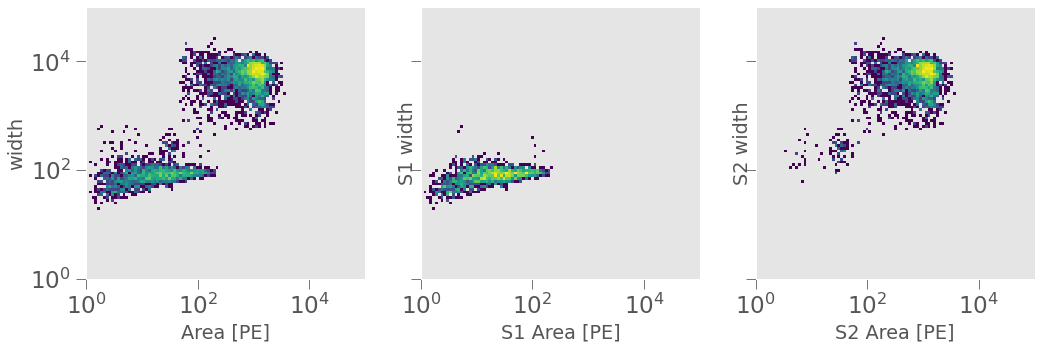

In [17]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(17,5), sharex=True, sharey=True)
ax0.grid(False); ax1.grid(False); ax2.grid(False)
ax0.hist2d(peak_basics["area"], peak_basics["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax0.set_xscale("log"); ax0.set_yscale("log")
ax0.set_xlabel("Area [PE]"); ax0.set_ylabel("width");


ax1.hist2d(peak_s1["area"], peak_s1["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax1.set_xscale("log"); ax1.set_yscale("log")
ax1.set_xlabel("S1 Area [PE]"); ax1.set_ylabel("S1 width");

ax2.hist2d(peak_s2["area"], peak_s2["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xlabel("S2 Area [PE]"); ax2.set_ylabel("S2 width");

### Test different simulation configurations

In [18]:
import cutax, strax
st2 = cutax.contexts.xenonnt_sim_SR0v2_cmt_v8(cmt_run_id="026000", 
                                              output_folder=os.path.join(m.config['wfsim']['sim_folder'], "strax_data"))
# set s1 minimum coincidence to 0
st2.set_config({"s1_min_coincidence":0})

In [19]:
st2 = m.simulate_one(df, "Nakazato7_highstat_st2", context=st2)

> Saved at <self.storage>/Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s20_0_fits.pickle!



Nakazato7_highstat_st2 already exists!
Nakazato7_highstat_st2 is fetched! Returning context!


In [21]:
peak_basics2 = st2.get_df("Nakazato7_highstat_st2", ["peak_basics","peak_positions"])

Loading plugins: |          | 0.00 % [00:00<?]

2022-08-25 04:29:06.046870: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/XENONnT/anaconda/envs/XENONnT_development/lib64:/opt/XENONnT/anaconda/envs/XENONnT_development/lib:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib:/opt/rh/devtoolset-9/root/usr/lib64/dyninst:/opt/rh/devtoolset-9/root/usr/lib/dyninst:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib
2022-08-25 04:29:06.046932: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-25 04:29:16.192658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/XENONnT/anaconda/envs

In [22]:
peak_s12 = peak_basics2[peak_basics2['type'] == 1]
peak_s22 = peak_basics2[peak_basics2['type'] == 2]
peak_basics2['type'].unique(), sum(peak_basics2['type']==0), sum(peak_basics2['type']==1), sum(peak_basics2['type']==2)

(array([2, 1, 0], dtype=int8), 27, 1594, 2866)

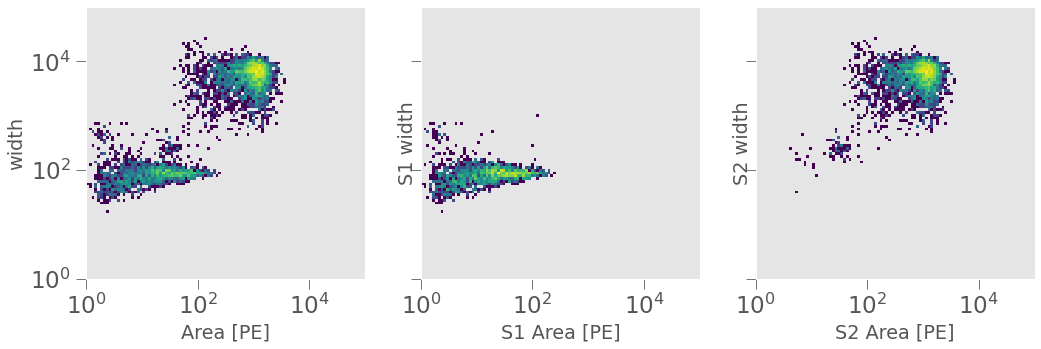

In [23]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(17,5), sharex=True, sharey=True)
ax0.grid(False); ax1.grid(False); ax2.grid(False)
ax0.hist2d(peak_basics2["area"], peak_basics2["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax0.set_xscale("log"); ax0.set_yscale("log")
ax0.set_xlabel("Area [PE]"); ax0.set_ylabel("width");


ax1.hist2d(peak_s12["area"], peak_s12["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax1.set_xscale("log"); ax1.set_yscale("log")
ax1.set_xlabel("S1 Area [PE]"); ax1.set_ylabel("S1 width");

ax2.hist2d(peak_s22["area"], peak_s22["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xlabel("S2 Area [PE]"); ax2.set_ylabel("S2 width");

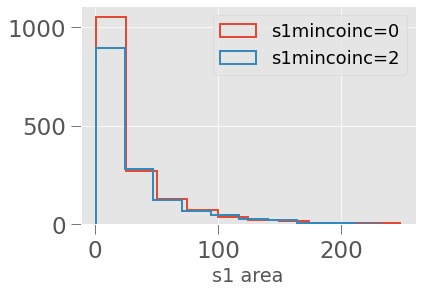

In [25]:
plt.hist(peak_s12['area'], bins=10, histtype='step', lw=2, label='s1mincoinc=0');
plt.hist(peak_s1['area'], bins=10, histtype='step', lw=2, label='s1mincoinc=2');
plt.xlabel('s1 area')
plt.legend();

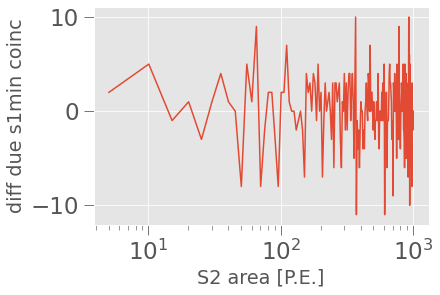

In [24]:
len(peak_s22), len(peak_s2)
bins = np.linspace(0, 1000, 200)
a = np.histogram(peak_s2['area'], bins=bins)[0]
b = np.histogram(peak_s22['area'], bins=bins)[0]
plt.semilogx(bins[1:], a-b)
plt.xlabel("S2 area [P.E.]");
plt.ylabel("diff due s1min coinc");

### Test the plugin

In [26]:
from sn_rate_plugin import SNPugins
st.register(SNPugins)

sn_rate_plugin.SNPugins

Loading sn_rate: |          | 0.00 % [00:00<?]

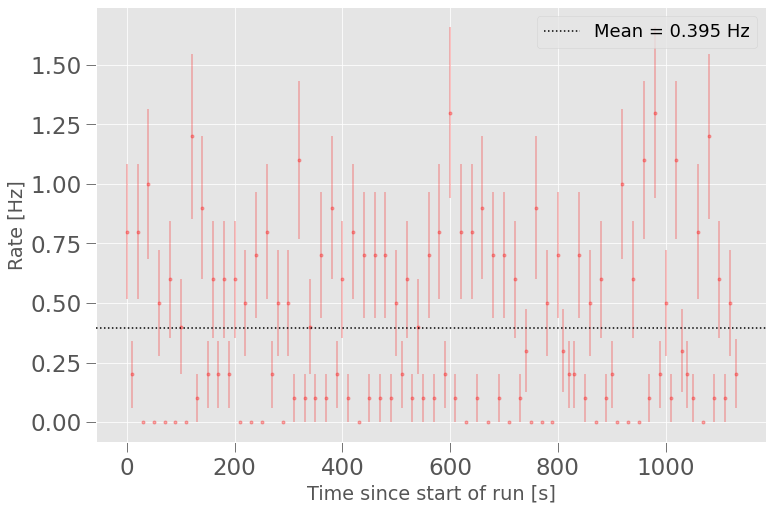

In [27]:
st.set_config({"sn_time_bin":10})
df_rate = st.get_df("Nakazato7_highstat", 'sn_rate')
plt.figure(figsize=(12,8))
plt.errorbar(x=(df_rate['time']-df_rate['time'][0])/1e9, 
             y=df_rate['sn_rate'],
             yerr=df_rate['sn_rate_err'], 
             color='r', marker='.',linestyle='',alpha=0.3)
plt.axhline(np.mean(df_rate['sn_rate']), color='k',linestyle=':', 
            zorder=10, label='Mean = %.3f Hz'%np.mean(df_rate['sn_rate']))

plt.legend()
plt.xlabel('Time since start of run [s]')
plt.ylabel('Rate [Hz]')
plt.show()

# Looking at the events for 2 contexts

In [29]:
events = st.get_df("Nakazato7_highstat", "event_basics")
events2 = st2.get_df("Nakazato7_highstat_st2", "event_basics")

In [30]:
events

,time,endtime,n_peaks,drift_time,event_number,s1_index,alt_s1_index,s1_time,alt_s1_time,s1_center_time,...,alt_s2_x_cnn,alt_s2_y_cnn,s2_x_gcn,s2_y_gcn,alt_s2_x_gcn,alt_s2_y_gcn,s2_x_mlp,s2_y_mlp,alt_s2_x_mlp,alt_s2_y_mlp
0,32856425,35688670,2,NaN,0,-1,-1,-1,-1,-1,...,12.679173,49.060291,16.635736,20.230837,13.534935,49.140373,16.116785,20.145599,13.038800,48.971001
1,51974416,54698110,2,1052826.0,1,0,-1,53387350,-1,53387476,...,NaN,NaN,50.695927,26.668797,NaN,NaN,50.984531,26.636404,NaN,NaN
2,56347656,62456290,6,NaN,2,-1,-1,-1,-1,-1,...,2.242389,-44.334583,-27.342686,-32.246319,2.946328,-43.847252,-27.711443,-32.147331,2.860001,-43.696659
3,95669576,98390920,1,NaN,3,-1,-1,-1,-1,-1,...,NaN,NaN,-35.890835,4.274988,NaN,NaN,-35.346725,4.004823,NaN,NaN
4,102350966,105079670,2,1637851.0,4,0,-1,103177900,-1,103177979,...,NaN,NaN,9.790612,1.241588,NaN,NaN,9.576033,1.276839,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2520,1135192319316,1135195031260,1,NaN,2520,-1,-1,-1,-1,-1,...,NaN,NaN,28.098192,-21.553663,NaN,NaN,28.461000,-21.219097,NaN,NaN
2521,1135480047356,1135482780480,2,1413444.0,2521,0,-1,1135481099300,-1,1135481099364,...,NaN,NaN,-28.766884,31.947933,NaN,NaN,-28.741976,31.341721,NaN,NaN
2522,1139457559956,1139460285840,2,1954478.0,2522,0,-1,1139458070490,-1,1139458070584,...,NaN,NaN,27.954384,4.167039,NaN,NaN,27.913635,4.008578,NaN,NaN
2523,1139956065406,1139958789610,1,NaN,2523,-1,-1,-1,-1,-1,...,NaN,NaN,4.480878,-28.035082,NaN,NaN,4.083737,-26.961964,NaN,NaN


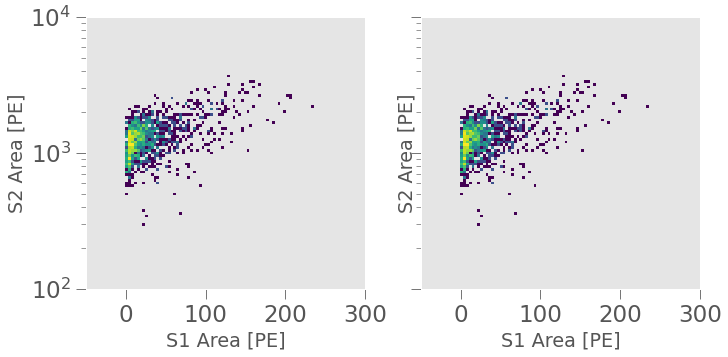

In [48]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(11,5), sharex=True, sharey=True)
ax0.grid(False); ax1.grid(False);

ax0.hist2d(events["s1_area"], events["s2_area"], 
           bins=(np.linspace(-50,300,100),np.logspace(2,4,100)),
           norm=LogNorm());
ax0.set_yscale("log")
ax0.set_xlabel("S1 Area [PE]"); ax0.set_ylabel("S2 Area [PE]");


ax1.hist2d(events["s1_area"], events["s2_area"], 
           bins=(np.linspace(-50,300,100),np.logspace(2,4,100)),
           norm=LogNorm());
ax1.set_yscale("log")
ax1.set_xlabel("S1 Area [PE]"); ax1.set_ylabel("S2 Area [PE]");

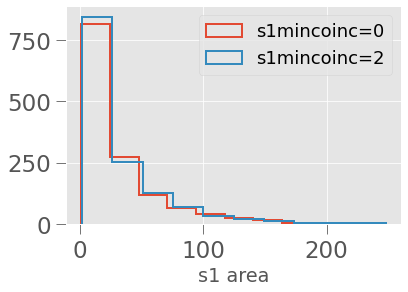

In [49]:
plt.hist(events['s1_area'], bins=10, histtype='step', lw=2, label='s1mincoinc=0');
plt.hist(events2['s1_area'], bins=10, histtype='step', lw=2, label='s1mincoinc=2');
plt.xlabel('s1 area')
plt.legend();

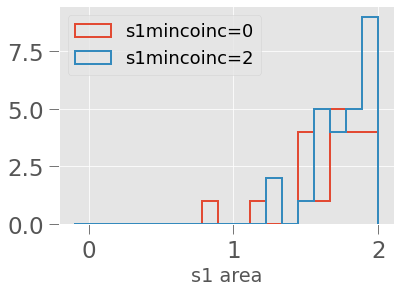

In [66]:
plt.hist(events['s1_area'], bins=np.linspace(-0.1,2,20), histtype='step', lw=2, label='s1mincoinc=0');
plt.hist(events2['s1_area'], bins=np.linspace(-0.1,2,20), histtype='step', lw=2, label='s1mincoinc=2');
plt.xlabel('s1 area')
plt.legend(loc='upper left');

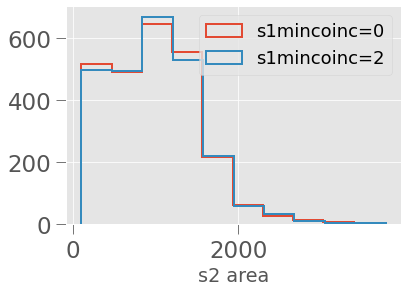

In [50]:
plt.hist(events['s2_area'], bins=10, histtype='step', lw=2, label='s1mincoinc=0');
plt.hist(events2['s2_area'], bins=10, histtype='step', lw=2, label='s1mincoinc=2');
plt.xlabel('s2 area')
plt.legend();